# Fieldfield correction algorithm test

Measured images from a fluorescence microscope is not entire uniform across the field of view due to non-uniform illumination, optics, and camera. Final result is 

Image_measured(x,y) = Image_true(x,y) * Fore-ground (x,y) + Back-ground(x,y)

We want to recover the true image from the following algorithm. 

<ol>
    <li> Select a frame </li>
    <li> Segmentation using local thresholding algorithm to find fore-ground vs back-ground pixels </li>
    <li> For each frame, do the following </li>
    <li> Sweep through each pixel (row, col) and do the following </li>
    <li> Select a box around the pixel (e.g. 10x10 window size) and get the mean or median of bg or fg </li>
    <li> Leave zero if there's no bg or fg signal in the box </li>
    <li> Continue for all the pixels > get each fg and bg image per frame </li>
    <li> Repeat 4)-6) for all the frames </li>
    <li> For each pixel, get the median or mean from all frames </li>
    <li> For each frame, subtract bg and divided by fg images to obtain the true image </li>
</ol>


## Import library

In [1]:
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from pathlib import Path  
import os
import shutil
#from scipy.optimize import curve_fit
from skimage.feature import peak_local_max
from skimage.filters import median
from skimage.morphology import disk
from skimage.filters import rank
from scipy.stats import norm
import sys
sys.path.append("../apc/apc")   # Path where apc_config and apc_funcs are located
from apc_config import data_dir # Configuration 
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import threshold_sauvola, threshold_niblack, threshold_local

# User-defined functions
from apc_funcs import read_movie, running_avg, reject_outliers, str2bool, \
flatfield_correct, drift_correct, reject_outliers, get_trace, fit_trace

## User input

In [2]:
directory = data_dir/'19-05-29 Movies 300pix300pi'/'data2'/'10.10.18_antiStrep_APC_pNH72_NHP2-100pM-PCAPCD_200frames_1s_2'

## Configure movie

In [3]:
movie_paths = list(directory.glob('**/*.tif'))
movie_path = movie_paths[0]
movie_dir = movie_path.parent
movie_name = movie_path.name
spot_size = 3
print('Directory:', movie_dir)
print('Name:', movie_name)

Directory: /home/jmsung/Dropbox/projects/apc/data/19-05-29 Movies 300pix300pi/data2/10.10.18_antiStrep_APC_pNH72_NHP2-100pM-PCAPCD_200frames_1s_2
Name: antiStrep_APC_pNH72_NHP2-100pM-PCAPCD_200frames_1s_2_MMStack_Pos0.ome.tif


## Read movie

In [4]:
from tifffile import TiffFile
with TiffFile(movie_path) as tif:
    I_original = tif.asarray()

n_frame = np.size(I_original, axis=0)
n_row = np.size(I_original, axis=1)
n_col = np.size(I_original, axis=2) 
print('[frame, row, col] = [%d, %d, %d]' %(n_frame, n_row, n_col)) 

[frame, row, col] = [200, 300, 300]


## Segmentation of one frame

/home/jmsung/miniconda/envs/apc/lib/python3.7/site-packages/skimage/filters/rank/generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (2020), equivalent to an approximate bitdepth of 11.0.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))


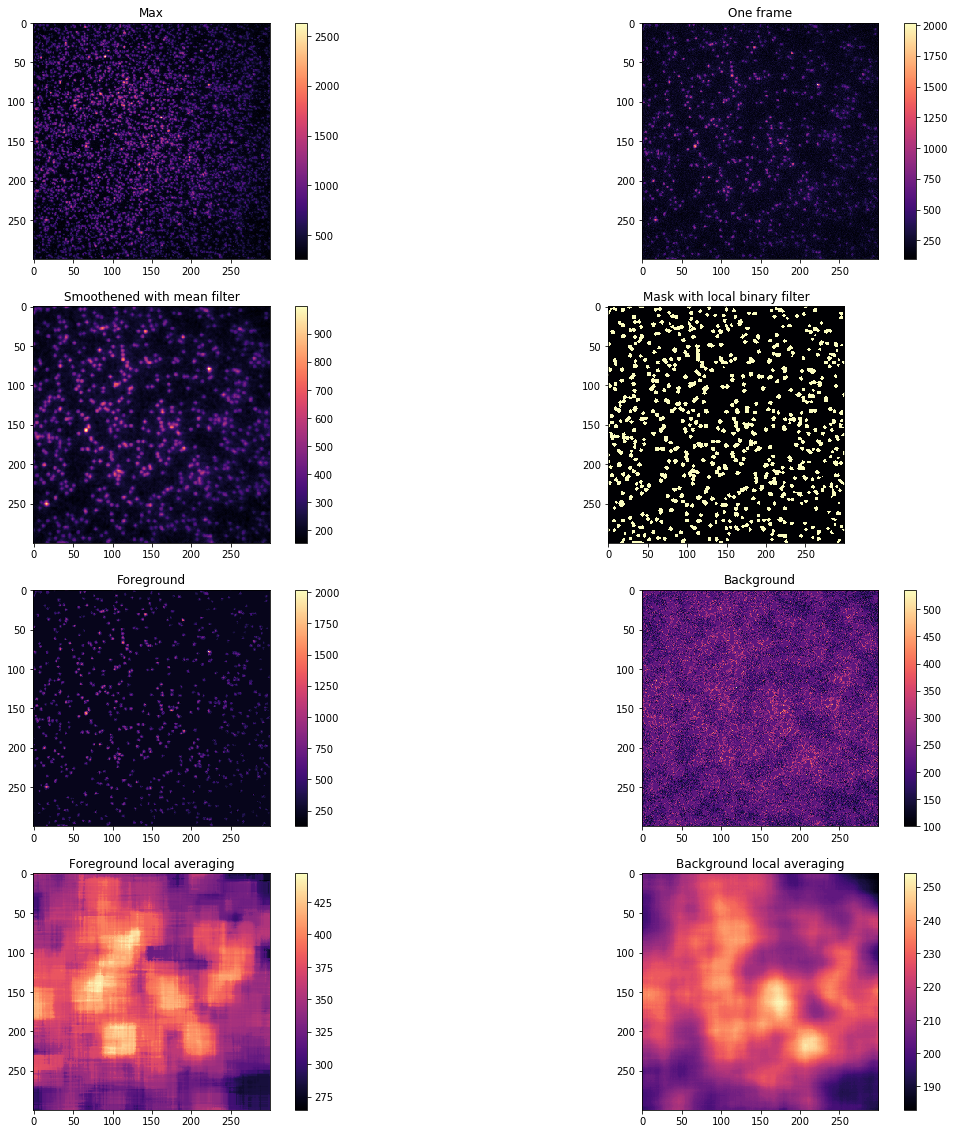

In [5]:
from scipy.ndimage import gaussian_filter, median_filter
from skimage.morphology import disk
from skimage.filters import rank
from skimage.filters.rank import entropy
from skimage.filters import threshold_sauvola, threshold_niblack, threshold_local

# Select an image frame
I_frame = np.squeeze(I_original[0,:,:])
I_max = np.squeeze(np.max(I_original, axis=0))
#I_frame = np.squeeze(np.mean(I_original, axis=0))

# Smoothening with mean filter
#I_filter = I_frame
I_filter = rank.mean(I_frame, selem=disk(2))

# Masking with local binary filter
mask = I_filter > threshold_local(I_filter, block_size=31, offset=-31) 

# Fore-ground and back-ground image
I_FG = I_frame*mask
I_BG = I_frame*(1-mask)

# Fill mean fg
I_FG_fill = I_FG.copy()
I_BG_fill = I_BG.copy()
bg = I_BG_fill.flatten()#.tolist()
mean_bg = np.mean([bg[i] for i in range(len(bg)) if bg[i] > 0])
I_BG_fill[I_BG_fill==0] = mean_bg
I_FG_fill[I_FG_fill==0] = mean_bg

# Local averaging FG and BG images
s = 20 #half-width of window size

FG = np.zeros((n_row, n_col))
BG = np.zeros((n_row, n_col))

for i in range(n_row):
    row_min = max(i-s, 0)
    row_max = min(i+s+1, n_row)   
    for j in range(n_col):
        col_min = max(j-s, 0)
        col_max = min(j+s+1, n_col) 
        FG_window = I_FG[row_min:row_max, col_min:col_max].flatten()
        BG_window = I_BG[row_min:row_max, col_min:col_max].flatten()
        FG[i,j] = np.median([fg for fg in FG_window if fg > 0])
        BG[i,j] = np.median([bg for bg in BG_window if bg > 0])

# Plot
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(figsize=(20, 20), nrows = 4, ncols=2)

sp0 = ax0.imshow(I_max, cmap=cm.magma)
ax0.set_title('Max') 
fig.colorbar(sp0, ax=ax0) 

sp1 = ax1.imshow(I_frame, cmap=cm.magma)
ax1.set_title('One frame') 
fig.colorbar(sp1, ax=ax1) 

sp2 = ax2.imshow(I_filter, cmap=cm.magma)
ax2.set_title('Smoothened with mean filter') 
fig.colorbar(sp2, ax=ax2) 

sp3 = ax3.imshow(mask, cmap=cm.magma)
ax3.set_title('Mask with local binary filter') 

sp4 = ax4.imshow(I_FG_fill, cmap=cm.magma)
ax4.set_title('Foreground') 
fig.colorbar(sp4, ax=ax4) 

sp5 = ax5.imshow(I_BG_fill, cmap=cm.magma)
ax5.set_title('Background') 
fig.colorbar(sp5, ax=ax5) 

sp6 = ax6.imshow(FG, cmap=cm.magma)
ax6.set_title('Foreground local averaging') 
fig.colorbar(sp6, ax=ax6) 

sp7 = ax7.imshow(BG, cmap=cm.magma)
ax7.set_title('Background local averaging') 
fig.colorbar(sp7, ax=ax7) 

## Segmentation of all the frames

/home/jmsung/miniconda/envs/apc/lib/python3.7/site-packages/skimage/filters/rank/generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (2020), equivalent to an approximate bitdepth of 11.0.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
/home/jmsung/miniconda/envs/apc/lib/python3.7/site-packages/skimage/filters/rank/generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1849), equivalent to an approximate bitdepth of 10.9.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
/home/jmsung/miniconda/envs/apc/lib/python3.7/site-packages/skimage/filters/rank/generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1854), equivalent to an approximate bitdepth of 10.9.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
/home/jmsung/miniconda/envs/apc/lib/python3.7/site-packages/skimage/filters/rank/generic.py:104: UserWarning: Bad rank filte

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

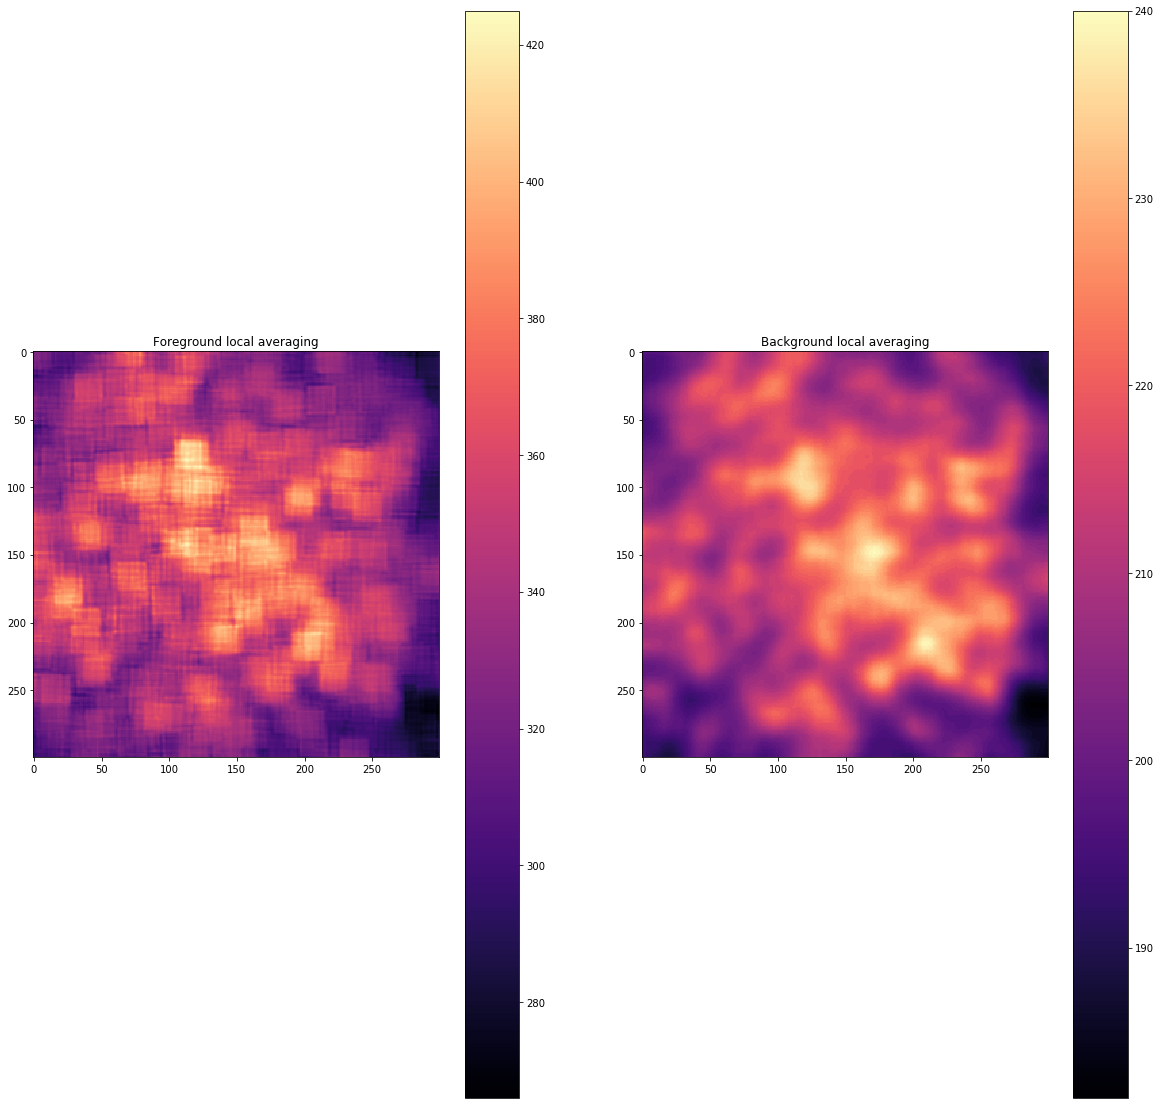

In [7]:
# Select an image frame

I_FG = np.zeros((n_frame, n_row, n_col))
I_BG = np.zeros((n_frame, n_row, n_col))

for i in range(n_frame):
    I_frame = np.squeeze(I_original[i,:,:])

    # Smoothening with mean filter
    #I_filter = I_frame
    I_filter = rank.mean(I_frame, selem=disk(2))

    # Masking with local binary filter
    mask = I_filter > threshold_local(I_filter, block_size=31, offset=-31) 

    # Fore-ground and back-ground image
    I_FG[i,] = I_frame*mask
    I_BG[i,] = I_frame*(1-mask)

# Local averaging FG and BG images
s = 10 #half-width of window size

FG = np.zeros((n_row, n_col))
BG = np.zeros((n_row, n_col))

for i in range(n_row):
    print(i)
    row_min = max(i-s, 0)
    row_max = min(i+s+1, n_row)   
    for j in range(n_col):
        col_min = max(j-s, 0)
        col_max = min(j+s+1, n_col) 
        FG_window = I_FG[:, row_min:row_max, col_min:col_max].flatten()
        BG_window = I_BG[:, row_min:row_max, col_min:col_max].flatten()
                       
        FG[i,j] = np.median([fg for fg in FG_window if fg > 0])
        BG[i,j] = np.median([bg for bg in BG_window if bg > 0])

# Plot
fig, ((ax6, ax7)) = plt.subplots(figsize=(20, 20), nrows = 1, ncols=2)

sp6 = ax6.imshow(FG, cmap=cm.magma)
ax6.set_title('Foreground local averaging') 
fig.colorbar(sp6, ax=ax6) 

sp7 = ax7.imshow(BG, cmap=cm.magma)
ax7.set_title('Background local averaging') 
fig.colorbar(sp7, ax=ax7)         
